# Problem : **Burgers Equation**

## 1 Partial Differential Equation

PDE :
$$\partial_t u+u\partial_x u - \nu\partial^2_{xx}u = 0 $$
$$x\in[-1,1], t\in[0,1]$$

Initial Condition :
$$u(x,0)=-\sin(\pi x)$$

Boundary Condition :
$$u(-1,t)=u(1,t)=0$$

### 1.1 **Import** *Libraries*

In [179]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "mps" if torch.backends.mps.is_available() else "cpu"

print(device)

cpu


### 1.2 **DEF** *Function*

#### 1.2.1 定义域

In [180]:
xMin = -1.0
xMax =  1.0
tMin = 0.0
tMax = 1.0

nu = 0.01/np.pi

#### 1.2.2 基本函数

In [181]:
def fIC(x,t):
  return -torch.sin(np.pi*x)

def fBC(x,t):
  return 0.0*x

### 1.3 展示理论公式

## 2 Neural Network

### 2.1 生成数据集

In [182]:
nIC=100
nBC=100
nDE=nIC*nBC

nTest = round(0.2*nDE)

#### 2.1.2 定义采样函数

In [183]:
def SmpIC(ran):
  x = xMin+ran*(xMax-xMin)
  t = tMin
  return torch.tensor([x,t])

def SmpBC_xL(ran):
  x = xMin
  t = tMin+ran*(tMax-tMin)
  return torch.tensor([x,t])

def SmpBC_xR(ran):
  x = xMax
  t = tMin+ran*(tMax-tMin)
  return torch.tensor([x,t])

def SmpDE(ran):
  x = xMin+ran[0]*(xMax-xMin)
  t = tMin+ran[1]*(tMax-tMin)
  return torch.tensor([x,t])

#### 2.1.3 随机采样

In [184]:
torch.manual_seed(123)

RanIC = torch.rand(nIC)
RanBC1 = torch.rand(nBC)
RanBC2 = torch.rand(nBC)
RanDE = torch.rand(nDE,2)
RanTest = torch.rand(nTest,2)

xtIC = torch.stack([SmpIC(ran) for ran in RanIC])
yIC = fIC(xtIC[:,0],xtIC[:,1]).unsqueeze(-1)

xtBC1 = torch.stack([SmpBC_xL(ran) for ran in RanBC1])
xtBC2 = torch.stack([SmpBC_xR(ran) for ran in RanBC2])
xtBC = torch.vstack([xtBC1,xtBC2])
yBC = fBC(xtBC[:,0],xtBC[:,1]).unsqueeze(-1)

xtIBC=torch.vstack([xtIC,xtBC]).float().to(device)
yIBC=torch.vstack([yIC,yBC]).float().to(device)

xtDE = torch.stack([SmpDE(ran) for ran in RanDE]).float().to(device)
xtDE = torch.vstack((xtIBC,xtDE))

xtTest = torch.stack([SmpDE(ran) for ran in RanTest]).float().to(device)

In [185]:
data = scipy.io.loadmat('C:\\Users\\73463\\Desktop\\Code\\NLT\\V4.9\\Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_DeepONets\\Data\\Burgers.mat')

x = data['x']                                   # 256 points between -1 and 1 [256x1]
t = data['t']                                   # 100 time points between 0 and 1 [100x1] 
usol = data['usol']                             # solution of 256x100 grid points
X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_test[0]  # [-1. 0.]
ub = X_test[-1] # [1.  0.99]
u_true = torch.tensor(usol.flatten('F')[:,None])
#Fortran style

### 2.2 Residual Definition

The residual will be:
$$R = R_{DE} + R_{BC} + R_{IC}$$

with
$$R_{DE}(x,t)=M_{t}(x,t)-M_{xx}(x,t)-S(x,t)$$
$$R_{BC}(x_{BC},t)=M(x_{BC},t) - f(x_{BC},t)$$
$$R_{IC}(x,t)=M(x,t_{IC}) - f(x,t_{IC})$$

$M(x)$ is the Neural Network Model prediction value of $f(x)$;

### 2.3 **DEF** *Neural Network*

#### 2.3.1 神经网络参数

In [186]:
steps=2000
lr=1e-4
layers = np.array([2,20,20,20,20,20,20,20,20,1])

#### 2.3.2 **DEF** *Function*

In [187]:
class FCN(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)

        # Additional Part
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b)#feature scaling
        #convert to float

        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(xtIBC,yIBC,xtDE)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            error_vec, _ = PINN.test()
            print(loss,error_vec)
            loss = PINN.lossDE(xtTest)
        return loss
                        
    def lossIBC(self,xtIBC,yIBC):
      lossIBC=self.loss_function(xtIBC,yIBC)
      return lossIBC

    def lossDE(self,xtDE):
        g = xtDE.clone()
        g.requires_grad = True
        u = self.forward(g)
        u_x_t = autograd.grad(u,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        u_xx_tt = autograd.grad(u_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]
        u_x = u_x_t[:,[0]]
        u_t = u_x_t[:,[1]]
        u_xx = u_xx_tt[:,[0]]
        fA = u_t + u*u_x
        fB = nu*u_xx 
        lossDE = self.loss_function(fA,fB)
        return lossDE
    
    def loss(self,xtIBC,yIBC,xtDE):
        lossIBC=self.lossIBC(xtIBC,yIBC)
        lossDE=self.lossDE(xtDE)
        loss = lossIBC + lossDE
        return loss
    
    'test neural network'
    def test(self):
        u_pred = self.forward(X_test)
        error_vec = torch.linalg.norm((u_true-u_pred),2)/torch.linalg.norm(u_true,2)        # Relative L2 Norm of the error (Vector)
        u_pred = u_pred.cpu().detach().numpy()
        u_pred = np.reshape(u_pred,(256,100),order='F')
        return error_vec, u_pred

In [188]:
PINN = FCN(layers)
PINN.to(device)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

#### 2.3.2 选择优化算法

In [189]:
#'''
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
'''

"\n'L-BFGS Optimizer'\noptimizer = torch.optim.LBFGS(PINN.parameters(), lr, \n                              max_iter = steps, \n                              max_eval = None, \n                              tolerance_grad = 1e-11, \n                              tolerance_change = 1e-11, \n                              history_size = 100, \n                              line_search_fn = 'strong_wolfe')\n"

### 2.4 迭代训练

In [190]:
start_time = time.time()

'''

optimizer.step(PINN.closure)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

error_vec, u_pred = PINN.test()
print('Test Error: %.5f'  % (error_vec))

'''

print("Training Loss-----Test Loss")
for i in range(steps):
    optimizer.zero_grad()
    loss = PINN.loss(xtIBC,yIBC,xtDE)
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss.detach().cpu().numpy())
    #  test_loss=PINN.lossDE(xtTest)
    #  print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

#'''

Training Loss-----Test Loss


c:\Users\73463\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([300, 1])) that is different to the input size (torch.Size([300, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

## 3. 模型预测结果

### 3.1 诊断函数

In [ ]:
tp = round(2./3.*t.shape[0])
tp_tensor = torch.tensor(t[tp,0]).expand(x.shape[0],1)

xt = torch.cat((torch.tensor(x), tp_tensor), dim=1)
y0 = torch.tensor(usol[:,tp]).unsqueeze(-1)
y1 = PINN(xt)

### 3.2 $M_{PINN}(x,t_p)$和$u_{True}(x,t_p)$

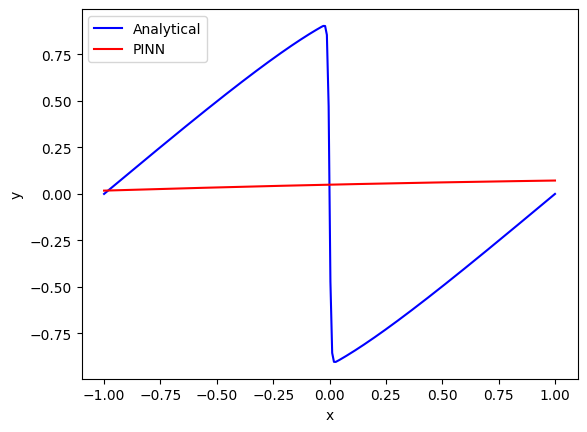

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(xt[:,0].detach().numpy(),y0[:,0].detach().numpy(),color='blue',label='Analytical')
ax1.plot(xt[:,0].detach().numpy(),y1[:,0].detach().numpy(),color='red',label='PINN')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

### 3.3 误差图$M_{PINN}(x,t_p)-f_{An}(x,t_p)$

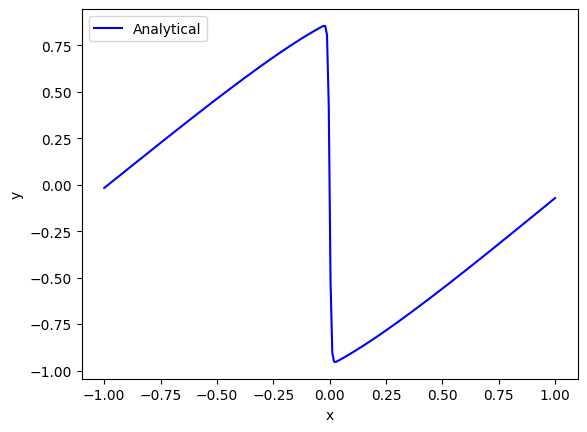

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(xt[:,0].detach().numpy(),(y0[:,0]-y1[:,0]).detach().numpy(),color='blue',label='Analytical')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('y',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

# Auxiliary Functions


In [ ]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [ ]:
def solutionplot(u_pred,X_u_train,u_train):
  #https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

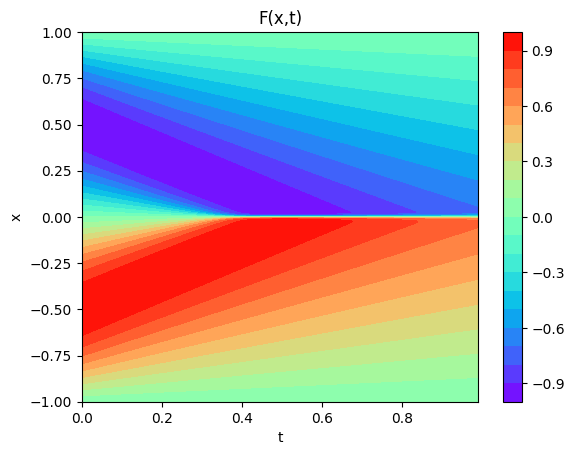

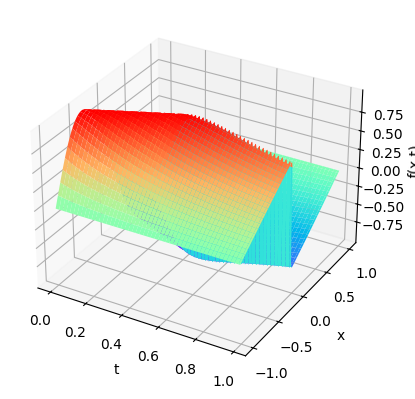

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) #f_real was defined previously(function)

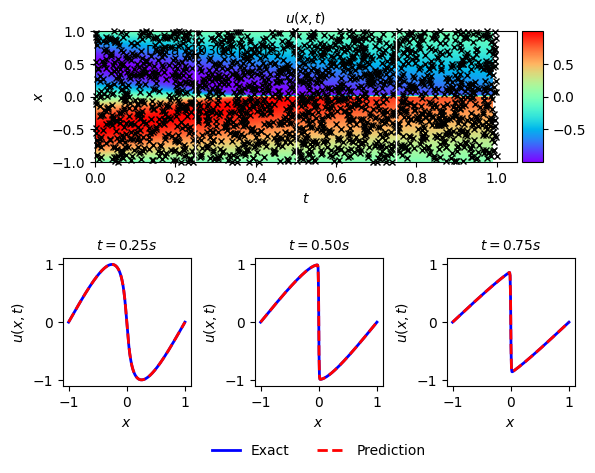

In [ ]:
solutionplot(usol,xtTest,PINN(xtDE))

### Plots

In [ ]:
x1=xtTest[:,0]
t1=xtTest[:,1]

In [ ]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_y1=usol
arr_y_test=usol

RuntimeError: shape '[100, 256]' is invalid for input of size 2000

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(arr_y1))

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation
